In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.utils import to_categorical

In [2]:
from evaluation.uncertainty_metrics import UncertaintyEvaluator, BootstrapEnsemble
from evaluation.TimeWindowModels.timeseries_utils import TimeSeriesUtils, MCDropout
from evaluation.viz_utils import plot_uncertainty_intervals, evaluate_uncertainty_utility

In [3]:
# === CONFIGURATION & DATA LOADING ===
SCRIPT_PATH = os.getcwd()
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'data', 'preprocessed', 'time_window_data'))
MODELS_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', '..', 'models'))
LABEL_ENCODER_PATH = os.path.join(DATA_DIR, 'label_encoder.pkl')

(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = TimeSeriesUtils.load_data(
    DATA_DIR, merge_train_val=True
)

unique_train, counts_train = np.unique(y_train_raw, return_counts=True)
print("Class distribiution in train set:", dict(zip(unique_train, counts_train)))
unique_test, counts_test = np.unique(y_test_raw, return_counts=True)
print("Class distribiution in test set:", dict(zip(unique_test, counts_test)))


Class distribiution in train set: {np.int64(0): np.int64(31161), np.int64(1): np.int64(31161), np.int64(2): np.int64(31161), np.int64(3): np.int64(31161)}
Class distribiution in test set: {np.int64(0): np.int64(5593), np.int64(1): np.int64(5593), np.int64(2): np.int64(5593), np.int64(3): np.int64(5593)}


In [4]:
# --- LABEL ENCODING ---
if y_test_raw.ndim > 1 and y_test_raw.shape[1] > 1:
    print("Detected One-Hot Encoded labels. Converting to Integers...")
    y_train = np.argmax(y_train_raw, axis=1)
    y_test = np.argmax(y_test_raw, axis=1)
else:
    print("Labels are already Integers.")
    y_train = y_train_raw
    y_test = y_test_raw

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Classes found: {np.unique(y_test)}")

# Load Label Encoder just for class names (for plots)
if os.path.exists(LABEL_ENCODER_PATH):
    le = joblib.load(LABEL_ENCODER_PATH)
    print(f"Class Names: {le.classes_}")
else:
    print("Warning: LabelEncoder not found. Using numeric labels.")

comparison_table = []
uncertainty_details = {}

Labels are already Integers.
y_train shape: (124644,)
y_test shape: (22372,)
Classes found: [0 1 2 3]
Class Names: ['faulty' 'faulty_zip' 'healthy' 'healthy_zip']


Running 50 MC simulations for LSTM...


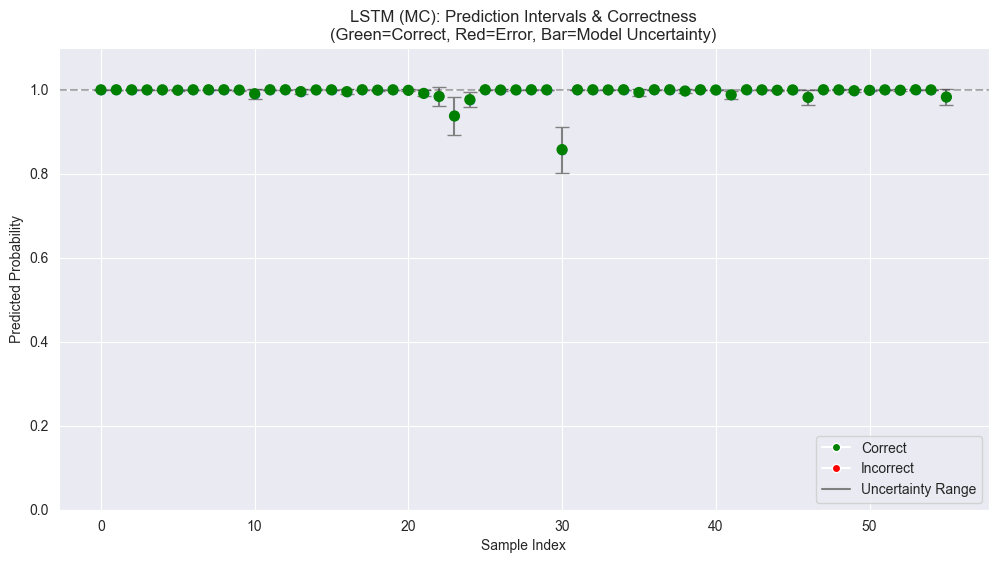

LSTM (MC) Error Detection AUC: 0.9462


In [5]:

# === 1. LSTM WITH MC DROPOUT ===
try:

    # Load model with custom object scope
    with tf.keras.utils.custom_object_scope({'MCDropout': MCDropout}):
        lstm_model = tf.keras.models.load_model(os.path.join(MODELS_DIR, 'lstm', 'lstm_mcdropout_final.keras'))

    # Extract Uncertainty via Monte Carlo Sampling
    probs_lstm, var_lstm, std_lstm = TimeSeriesUtils.predict_lstm_mc_uncertainty(lstm_model, X_test_raw)

    evaluator = UncertaintyEvaluator(y_test, "LSTM (MC)")
    metrics, entropy_lstm, _ = evaluator.compute_metrics(probs_lstm, epistemic_var=var_lstm)
    comparison_table.append(metrics)

    uncertainty_details["LSTM"] = entropy_lstm
    plot_uncertainty_intervals(y_test, probs_lstm, std_lstm, "LSTM (MC)")
    evaluate_uncertainty_utility(y_test, probs_lstm, entropy_lstm, "LSTM (MC)")

except Exception as e:
    print(f"LSTM Error: {e}")

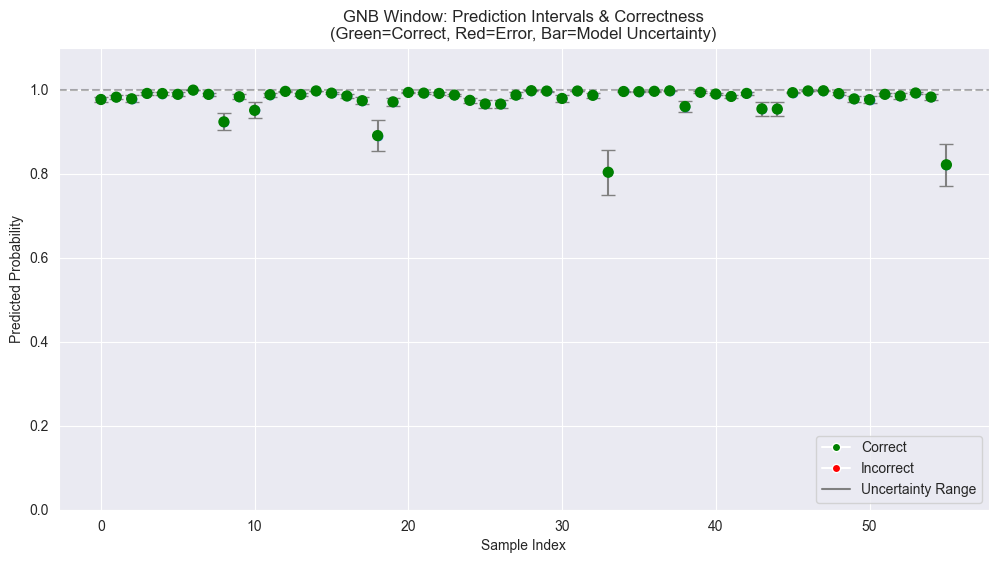

GNB Window Error Detection AUC: 0.7380


0.738025850838919

In [6]:
# === 2. GAUSSIAN NAIVE BAYES (Time Windows) ===
X_train_flat = TimeSeriesUtils.flatten_windows(X_train_raw)
X_test_flat = TimeSeriesUtils.flatten_windows(X_test_raw)

gnb_ensemble = BootstrapEnsemble(GaussianNB(), n_estimators=50)
gnb_ensemble.fit(X_train_flat, y_train)

probs_gnb_ens , var_gnb_ens, std_gnb_ens = gnb_ensemble.predict_proba_with_uncertainty(X_test_flat)

evaluator = UncertaintyEvaluator(y_test, "GNB Window")
metrics, entropy_gnb, _ = evaluator.compute_metrics(probs_gnb_ens, epistemic_var=var_gnb_ens)
comparison_table.append(metrics)

uncertainty_details["GNB Ensemble "] = entropy_gnb
plot_uncertainty_intervals(y_test, probs_gnb_ens, std_gnb_ens, "GNB Window")
evaluate_uncertainty_utility(y_test, probs_gnb_ens, entropy_gnb, "GNB Window")

In [7]:
# --- 3. GAUSSIAN NAIVE BAYES ---
try:
    gnb_path = os.path.join(MODELS_DIR, 'gnb_timeseries', 'gnb_timeseries.pkl')
    gnb_model = joblib.load(gnb_path)

    probs_gnb = gnb_model.predict_proba(X_test_flat)

    evaluator = UncertaintyEvaluator(y_test, "Gaussian NB")
    metrics, entropy_gnb, _ = evaluator.compute_metrics(probs_gnb)
    comparison_table.append(metrics)
    uncertainty_details["GNB"] = entropy_gnb
    print("GNB analyzed.")
except FileNotFoundError:
    print("GNB model not found.")

GNB analyzed.


,Accuracy,NLL,Brier Score,ECE,Avg Entropy (Total Uncertainty),Avg Epistemic Var
Model,,,,,,
LSTM (MC),0.949982,0.116625,0.070692,0.014749,0.148617,0.000542
GNB Window,0.846862,0.644041,0.239782,0.065638,0.196740,0.000619
Gaussian NB,0.848203,0.580453,0.235561,0.065869,0.194295,nan


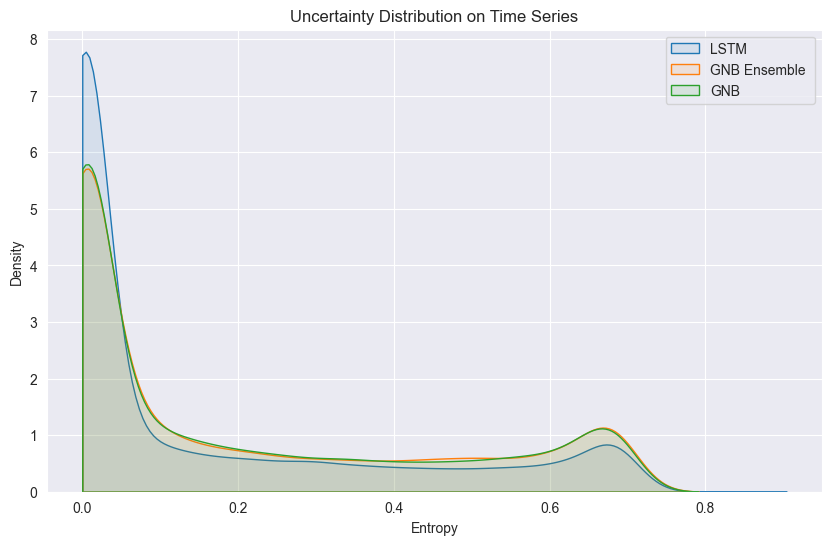

In [8]:

# === SUMMARY ===
if comparison_table:
    df_results = pd.DataFrame(comparison_table).set_index("Model")
    display(df_results.style.background_gradient(cmap='viridis', subset=['Accuracy'])\
                      .background_gradient(cmap='viridis_r', subset=['NLL', 'ECE']))

    # Distribution Plot
    plt.figure(figsize=(10, 6))
    for name, entropies in uncertainty_details.items():
        sns.kdeplot(entropies, label=name, clip=(0, None), fill=True, alpha=0.1)
    plt.title("Uncertainty Distribution on Time Series")
    plt.xlabel("Entropy")
    plt.legend()
    plt.show()